In [1]:
# Load Libraries

import os
import sys
import joblib
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima



In [2]:
# Add the 'scripts' folder to the Python path
scripts_path = os.path.abspath("../scripts")
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

# Load personal modules  
from wrangle import wrangle, merge_monthly_files, load_combined_series
from model_training import train_sarima_model, save_model, load_latest_model, forecast_with_model
from evaluate import evaluate_forecast, plot_forecast
from validate import load_latest_wfv_results, main

In [3]:
# wrangle data
filepath = "../data/monthly_p2_readings/2023_11.csv"

df = wrangle(filepath=filepath)
df.head()

,sensor_id,sensor_type,location,lat,lon,value_type,PM2.5
date,,,,,,,
2023-11-01 17:44:52.764459+01:00,4855,pms5003,3629,6.428,3.435,P2,19.00
2023-11-01 18:52:08.924982+01:00,4857,pms5003,3630,6.540,3.297,P2,3.50
2023-11-01 18:53:13.805911+01:00,4857,pms5003,3630,6.540,3.297,P2,3.00
2023-11-01 19:16:42.515782+01:00,4853,pms5003,3628,6.559,3.386,P2,40.33
2023-11-03 08:38:39.664224+01:00,4857,pms5003,3630,6.540,3.297,P2,47.00


In [4]:
# Cimbine multiple datasets

merge_monthly_files().head()

Processed 2023_11.csv
Processed 2023_12.csv
Processed 2024_01.csv
Processed 2024_02.csv
Processed 2024_03.csv
Processed 2024_04.csv
Processed 2024_05.csv
Processed 2024_06.csv
Processed 2024_07.csv
Processed 2024_08.csv
Processed 2024_09.csv
Processed 2024_10.csv
Processed 2024_11.csv
Processed 2024_12.csv
Processed 2025_01.csv
Processed 2025_02.csv
Processed 2025_03.csv
Processed 2025_04.csv

Combined shape: (73601, 7)


,sensor_id,sensor_type,location,lat,lon,value_type,PM2.5
date,,,,,,,
2023-11-01 17:44:52.764459+01:00,4855,pms5003,3629,6.428,3.435,P2,19.00
2023-11-01 18:52:08.924982+01:00,4857,pms5003,3630,6.540,3.297,P2,3.50
2023-11-01 18:53:13.805911+01:00,4857,pms5003,3630,6.540,3.297,P2,3.00
2023-11-01 19:16:42.515782+01:00,4853,pms5003,3628,6.559,3.386,P2,40.33
2023-11-03 08:38:39.664224+01:00,4857,pms5003,3630,6.540,3.297,P2,47.00


In [5]:
# Load Combined dataset into dataframe
train, test = load_combined_series()

print(f"Train split: {train.shape}")
print(f"Test split: {test.shape}")

Train split: (1654,)
Test split: (414,)


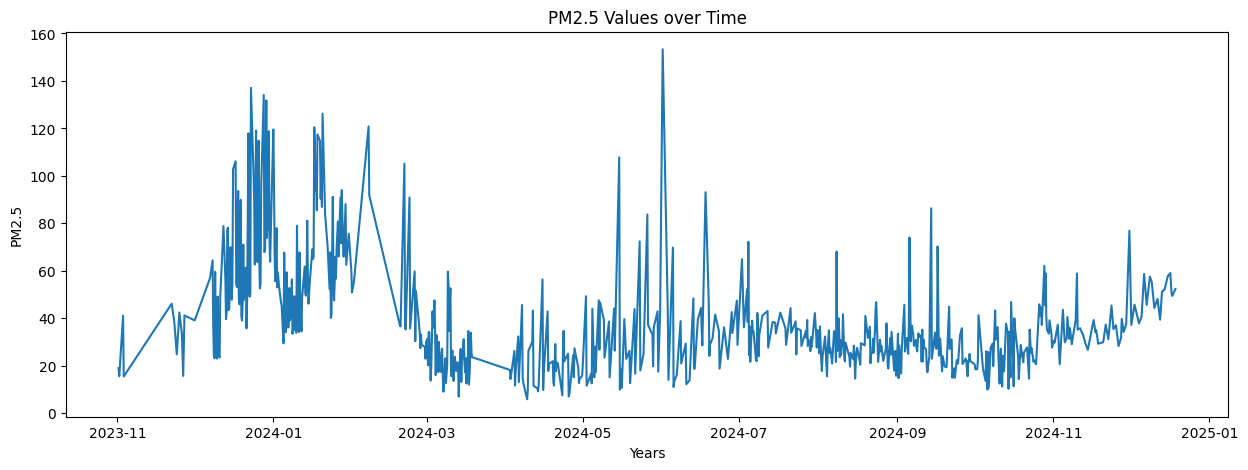

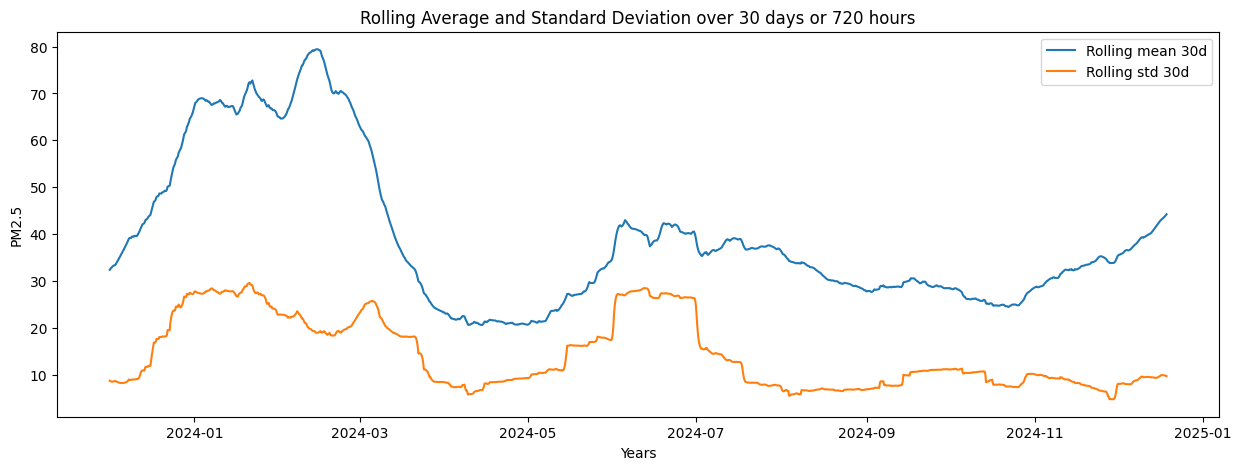

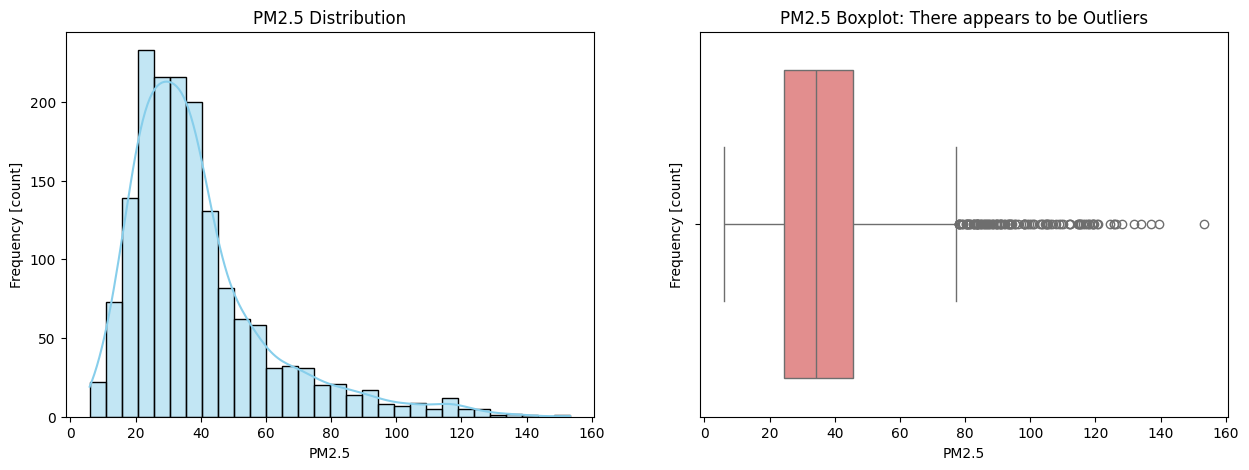

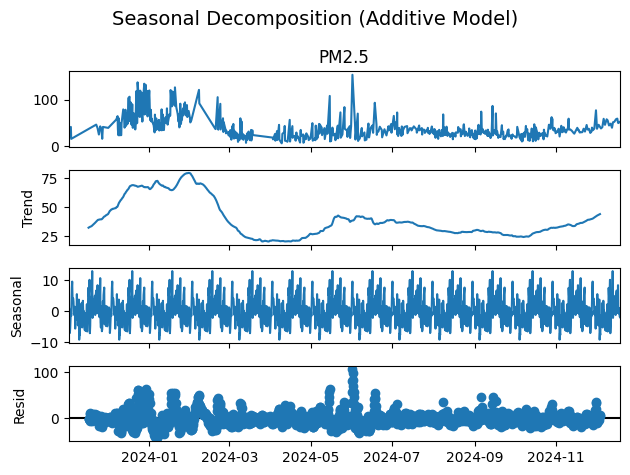

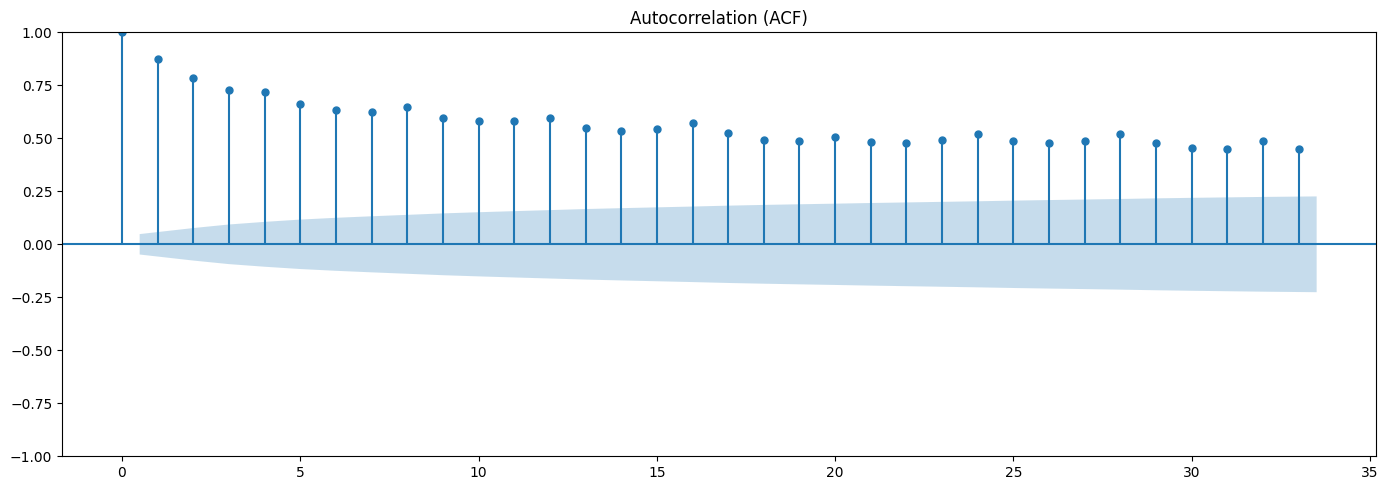

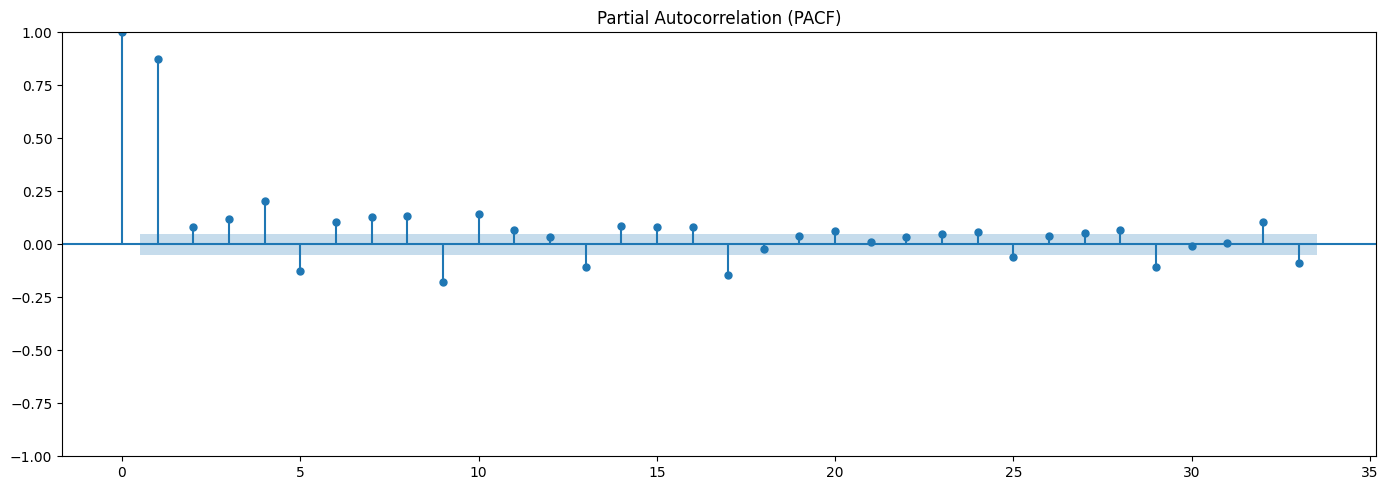

In [6]:
y = train

# PM2.5 Over time
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(y)
plt.title("PM2.5 Values over Time")
plt.xlabel("Years")
plt.ylabel("PM2.5")
plt.show()

window = 120
# rolling mean for 30 days or 720 hours
rolling_mean = y.rolling(window= window).mean()

# rolling variance for 30 days or 720 hours
rolling_std = y.rolling(window = window).std()

# Plot charts
fig, ax = plt.subplots(figsize = (15, 5))
plt.plot(rolling_mean, label = "Rolling mean 30d")
plt.plot(rolling_std, label = "Rolling std 30d")
plt.title("Rolling Average and Standard Deviation over 30 days or 720 hours")
plt.xlabel("Years")
plt.ylabel("PM2.5")

plt.legend()
plt.show()

# Figure size
plt.figure(figsize= (15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(y, kde=True, bins =  30, color= "skyblue")
plt.title("PM2.5 Distribution")
plt.ylabel("Frequency [count]")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y, color= "lightcoral", orient="h")
plt.title("PM2.5 Boxplot: There appears to be Outliers")
plt.ylabel("Frequency [count]")

plt.show()

period = 120

# Instantiate the seasonal_decompose
decomposition = seasonal_decompose(y, model="additive", period=period)

# Plot the Chart
decomposition.plot()
plt.suptitle("Seasonal Decomposition (Additive Model)", fontsize=14)
plt.tight_layout()
plt.show()

# plot_acf

fig, ax = plt.subplots(figsize=(14, 5))
plot_acf(y, ax=ax)
plt.title("Autocorrelation (ACF)")
plt.tight_layout()
plt.show()

# plot_pacf

fig, ax = plt.subplots(figsize=(14, 5))
plot_pacf(y, ax=ax)
plt.title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

# testing the created Scripts

In [15]:
# train model
model = train_sarima_model()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
model.summary()

C:\Users\user\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                PM2.5   No. Observations:                   96
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 28)   Log Likelihood               -1116.577
Date:                              Fri, 06 Jun 2025   AIC                           2249.154
Time:                                      23:13:52   BIC                           2266.299
Sample:                                  04-01-2018   HQIC                          2255.897
                                       - 04-24-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1527         -0       -inf      0.000       0.153       0.153
ar.L2         -0.7997         -0        inf      0.000      -0.800      -0.800
ma.L1         -0.7609   3.92e-30  -1.94e+29      0.000      -0.761      -0.761
ma.L2          0.6107    4.4e-30   1.39e+29      0.000       0.611       0.611
ma.L3         -0.4544   4.37e-29  -1.04e+28      0.000      -0.454      -0.454
ar.S.L28       0.0461   3.98e-32   1.16e+30      0.000       0.046       0.046
ma.S.L28    5.014e+13   9.05e-33   5.54e+45      0.000    5.01e+13    5.01e+13
sigma2       1.57e-13   2.39e-10      0.001      0.999   -4.68e-10    4.69e-10
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                61.74
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               7.65   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
# save_model
save_model(model)

In [7]:
# load model
model = load_latest_model()
print(type(model))

Loaded model: 2025-06-06T22-11-48_sarima_model.pkl
<class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>


In [8]:
# forecast
y_pred = forecast_with_model(model)
y_pred.head()

2024-12-19 00:00:00+01:00    52.560571
2024-12-19 06:00:00+01:00    52.659373
2024-12-19 12:00:00+01:00    51.472220
2024-12-19 18:00:00+01:00    51.723065
2024-12-20 00:00:00+01:00    51.965053
Freq: 6h, Name: predicted_mean, dtype: float64

In [9]:
# loading latest Walk forward validation file
wfv_df = load_latest_wfv_results()

wfv_df.head()

Loaded WFV results: 2025-06-06T22-52-39_walk_forward_results.csv


,y_test,y_pred
date,,
2024-12-19 00:00:00+01:00,52.919605,51.834598
2024-12-19 06:00:00+01:00,53.500504,52.173700
2024-12-19 12:00:00+01:00,54.081404,52.613437
2024-12-19 18:00:00+01:00,54.662303,53.396227
2024-12-20 00:00:00+01:00,55.243202,54.618110


MSE: 43.70078097268905
MAE: 3.348037588821062


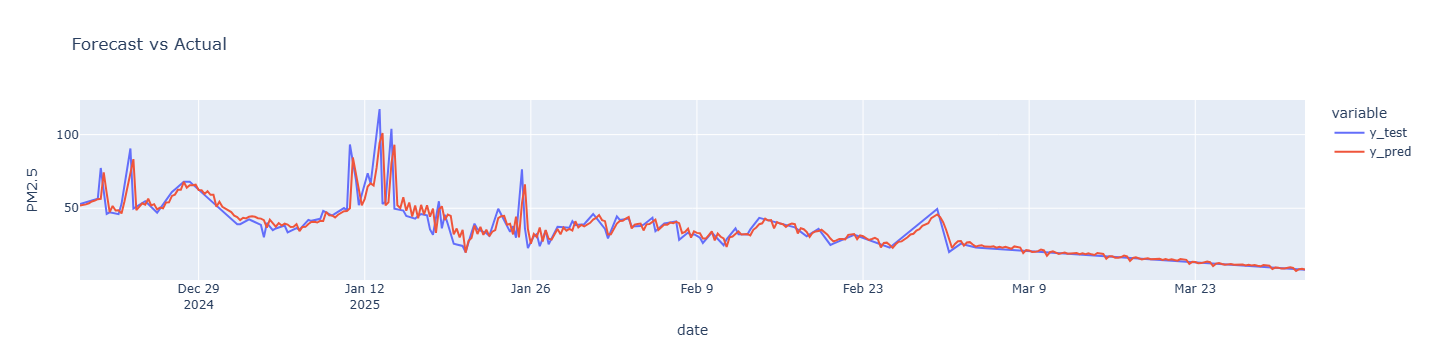

In [10]:
# Evaluate model

mse, mae = evaluate_forecast(test, wfv_df["y_pred"])

print(f"MSE: {mse}")
print(f"MAE: {mae}")

# plot Evaluation

plot_forecast(test, wfv_df["y_pred"])

In [11]:
# Testing the 'main' pipeline
wfv_df, mse, mae = main(train, test)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

wfv_df.head()

Loaded WFV results: 2025-06-06T22-52-39_walk_forward_results.csv
Walk-forward Validation - MSE: 43.70, MAE: 3.35
Walk-forward validation results saved as 2025-06-06T23-17-17_walk_forward_results.csv
MSE: 43.70078097268905
MAE: 3.348037588821062


,y_test,y_pred
date,,
2024-12-19 00:00:00+01:00,52.919605,51.834598
2024-12-19 06:00:00+01:00,53.500504,52.173700
2024-12-19 12:00:00+01:00,54.081404,52.613437
2024-12-19 18:00:00+01:00,54.662303,53.396227
2024-12-20 00:00:00+01:00,55.243202,54.618110
